# Generate a PPi train set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`

first number is number of IDs, second is number of PPIs

    | APID     |              ISI |            noISI |      loss |
    |---------:|:----------------:|:----------------:|:---------:|
    | w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
    | no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
    |     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [1]:
from __future__ import annotations

import importlib

from dataclasses import dataclass, field
from dataclass_wizard import JSONWizard

In [2]:
from data.utils import api, extract, general, pairs, plot, reduce

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *

In [3]:

@dataclass
class Config(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    keep_homodimers: bool = False
    rostclust_pretend: bool = True

    ap: Path = Path('apid_sequences')
    hp: Path = Path('huri_sequences')
    qp: Path = None

    min_seq_len: int = 50
    max_seq_len: int = 1500

    psi_path = Path('hi_union.psi')
    hval_config: dict = field(default_factory=dict)

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = None

    val_raw_fasta: Path = ap / 'apid_validation_raw.fasta'
    val_raw_tsv: Path = ap / 'apid_validation_raw.tsv'
    val_rr_fasta: Path = ap / 'apid_validation_rr.fasta'
    val_rr_tsv: Path = ap / 'apid_validation_rr.tsv'
    val_c3_fasta: Path = ap / 'apid_validation_c3.fasta'
    val_fasta: Path = Path('apid_validation.fasta')
    val_tsv: Path = Path('apid_validation.tsv')

    test_raw_fasta: Path = hp / 'huri_test_raw.fasta'
    test_raw_tsv: Path = hp / 'huri_test_raw.tsv'
    test_rr_fasta: Path = hp / 'huri_test_rr.fasta'
    test_rr_tsv: Path = hp / 'huri_test_rr.tsv'
    test_c3_fasta: Path = hp / 'huri_test_c3.fasta'
    test_fasta: Path = Path('huri_test.fasta')
    test_tsv: Path = Path('huri_test.tsv')

    train_tsv: Path = Path('apid_train.tsv')
    train_fasta: Path = Path('apid_train.fasta')
    train_positives: Path = ap / 'apid_train_positives.tsv'


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

c = Config(hval_config=hval_config)

In [4]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *

## Toy example
#### bias of negative dataset

In [14]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [15]:
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED)
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

aim for 19 negatives; upper limit is 53
got 19 negatives with bias 0.719


In [16]:
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM)
# random sampling gives a nearly un-biased dataset

aim for 19 negatives; upper limit is 53
got 19 negatives with bias -0.122


In [17]:
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED)
# sampling the entire network complement will perfectly invert the degree distribution

aim for 130 negatives; upper limit is 53
got 53 negatives with bias -1.000


#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

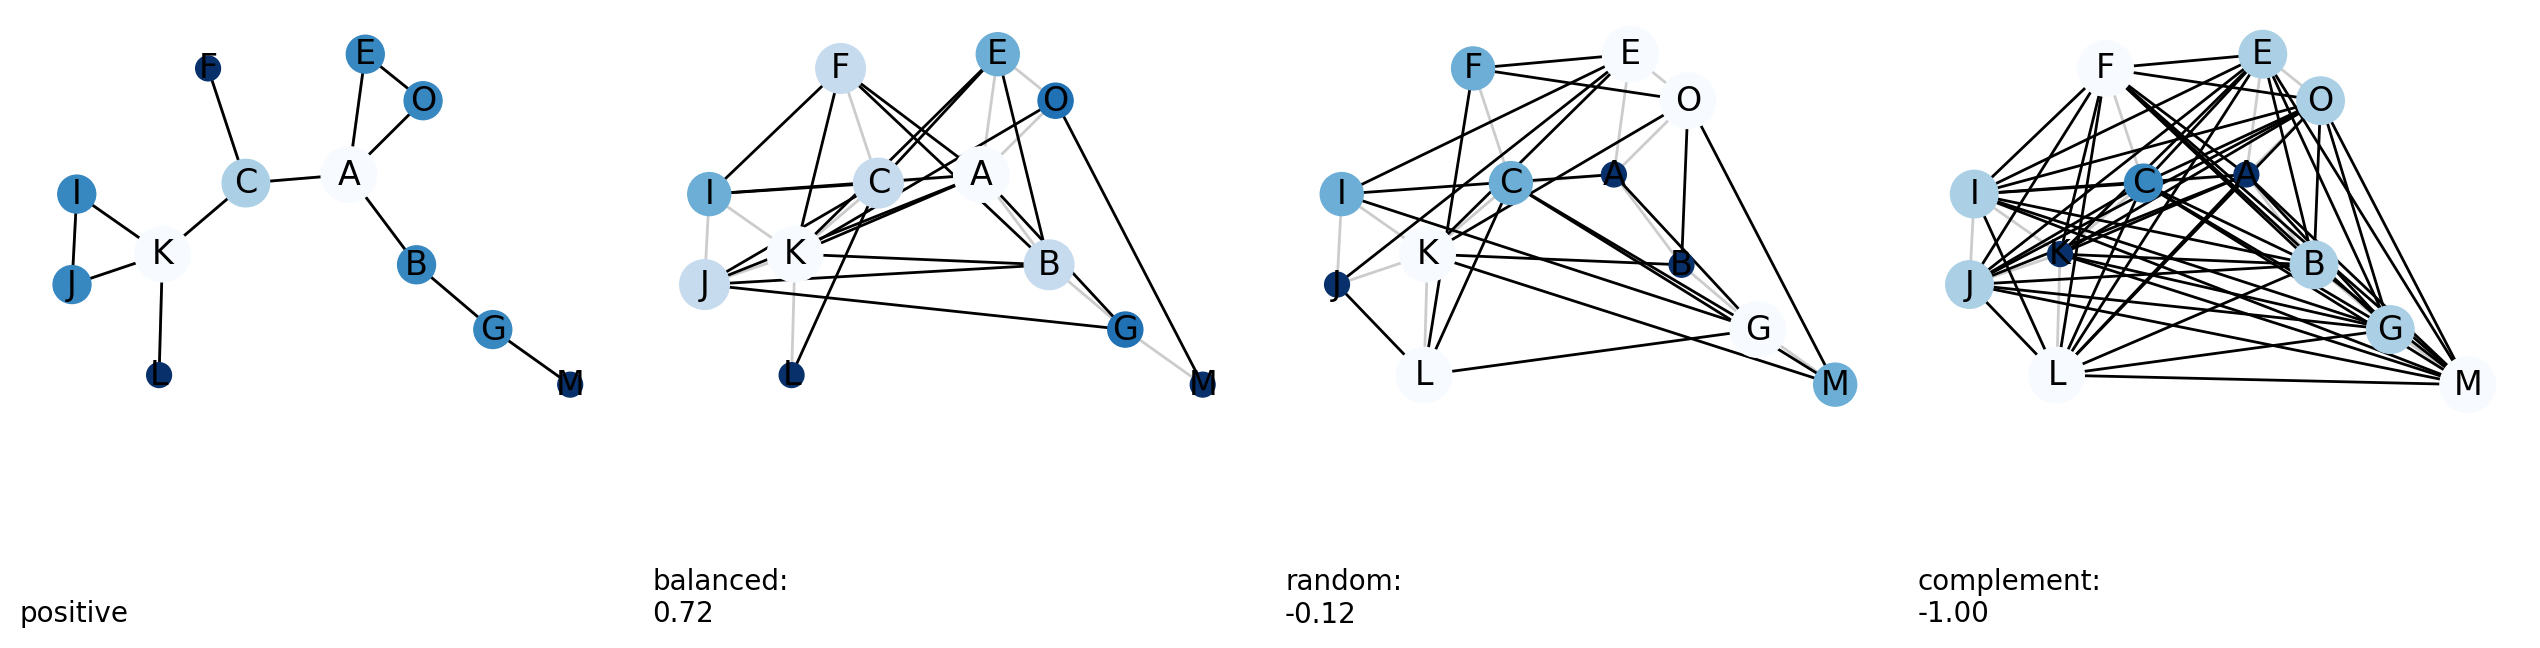

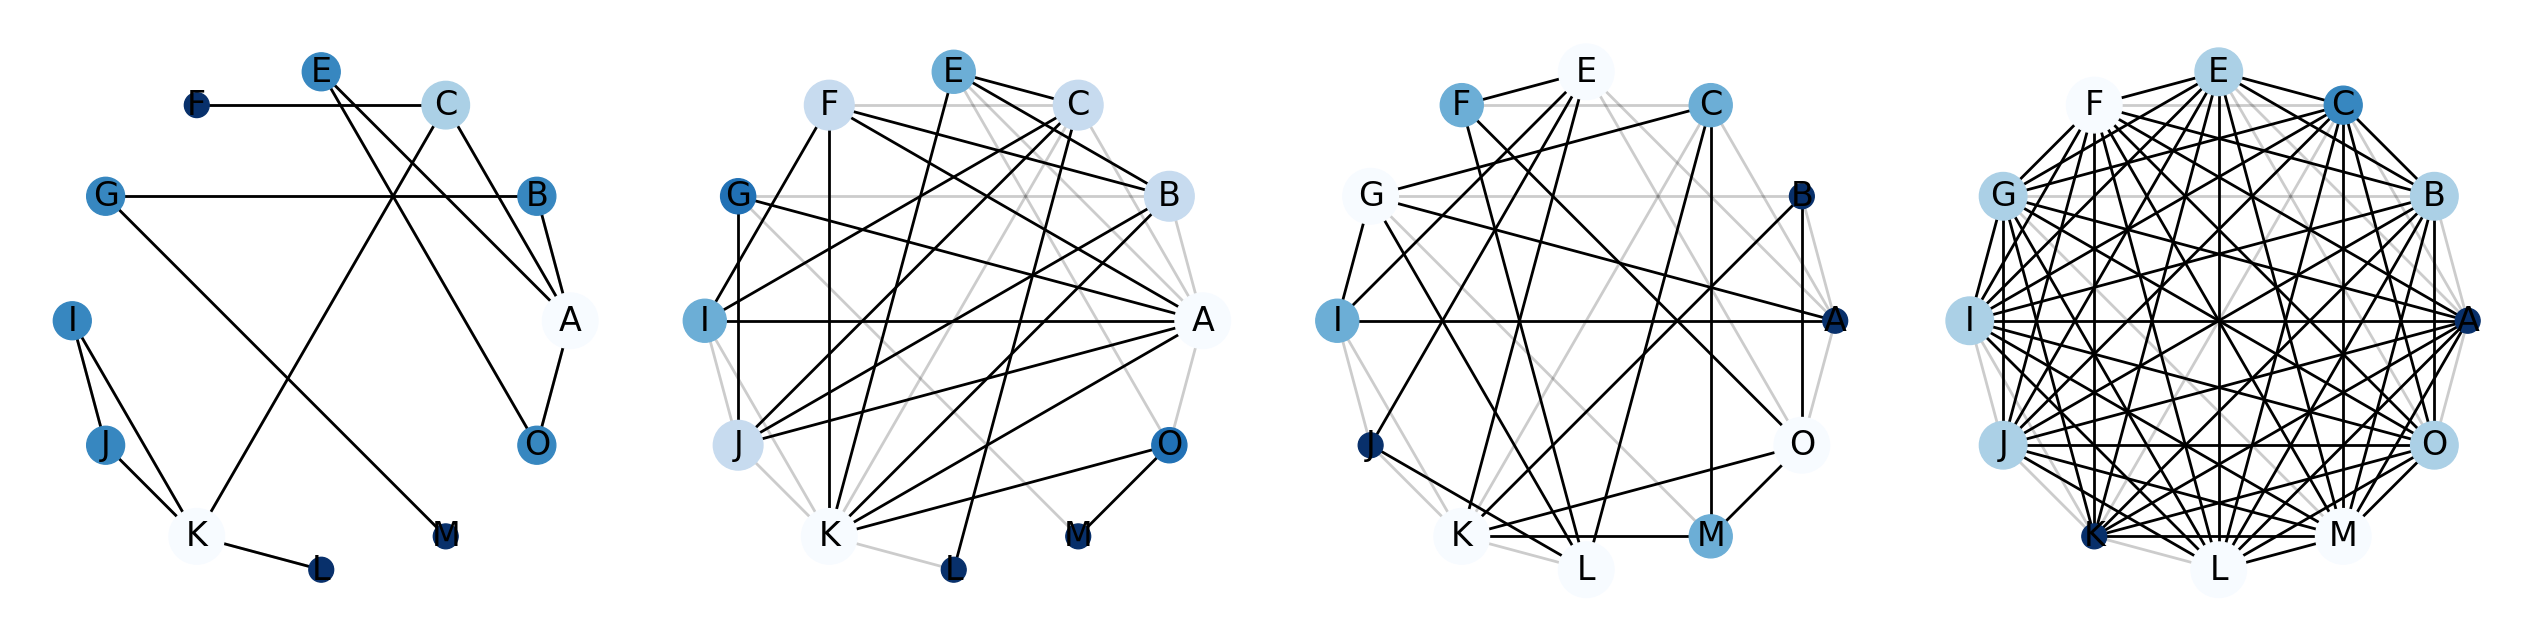

In [18]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [19]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

homo limit 64.0
aim for 21 negatives; upper limit is 64
got 21 negatives with bias 0.699
homo limit 64.0
aim for 21 negatives; upper limit is 64
got 21 negatives with bias -0.215
homo limit 64.0
aim for 140 negatives; upper limit is 64
got 64 negatives with bias -1.000


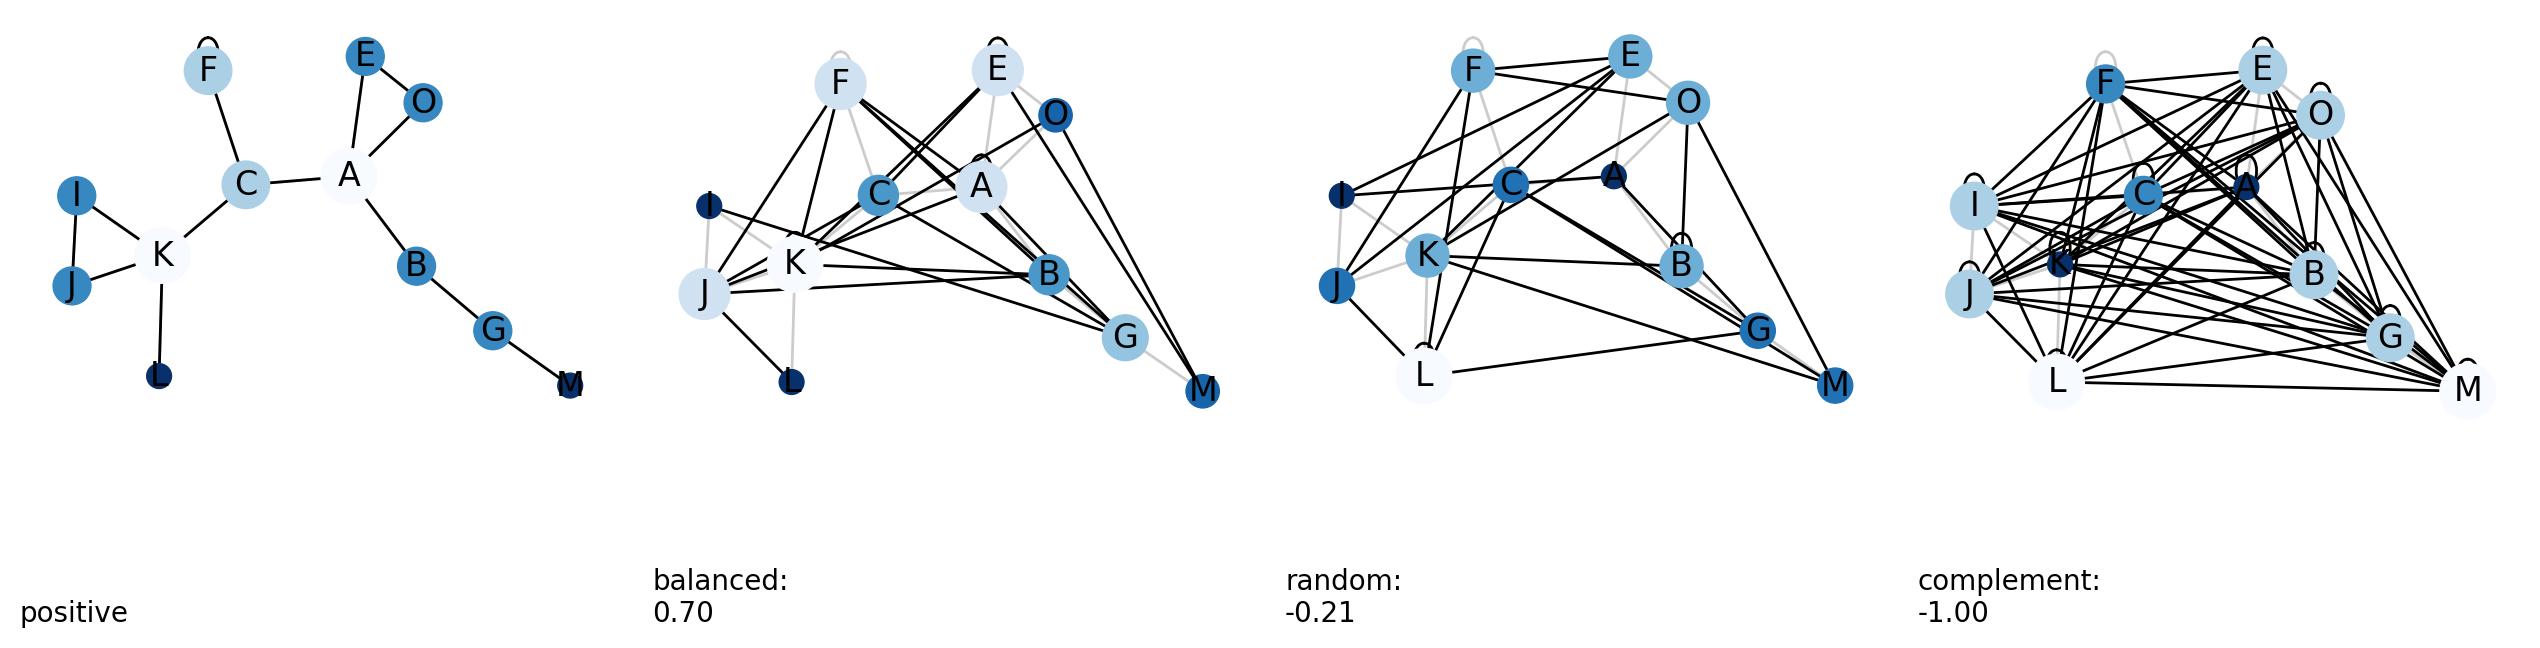

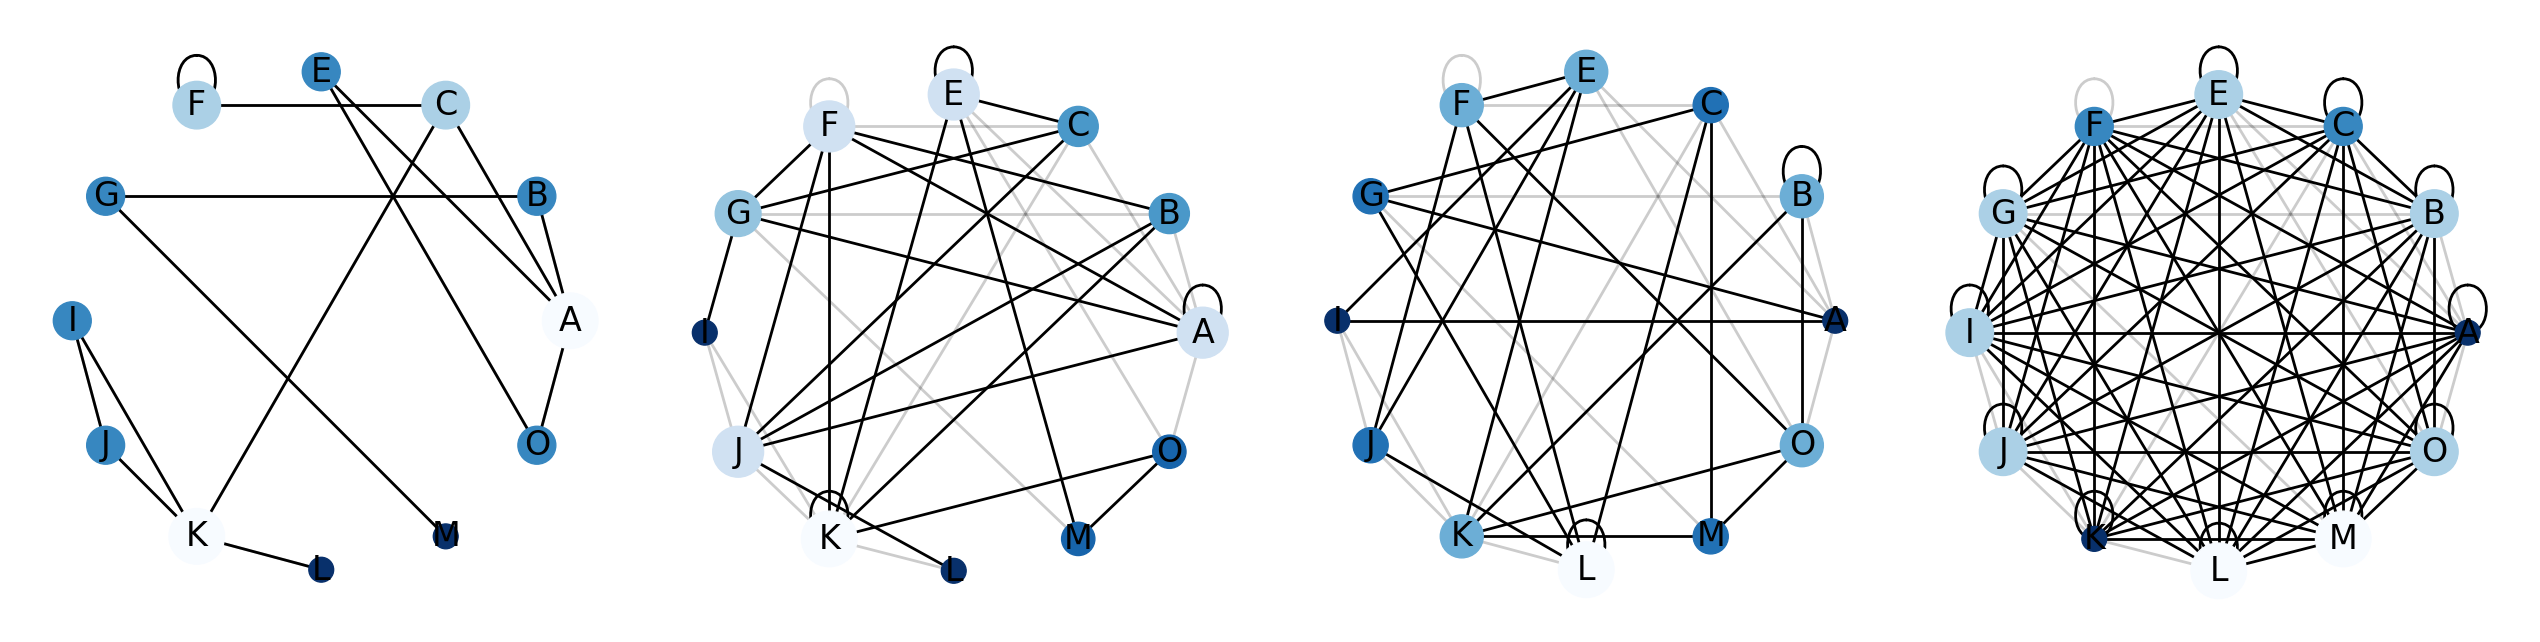

In [20]:
ppi_dict = dict()
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED)
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM)
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED)
_ = draw_toy_ppis(ppis, ppi_dict)

#### with, but not allowed

aim for 21 negatives; upper limit is 53
got 21 negatives with bias 0.603
aim for 21 negatives; upper limit is 53
got 21 negatives with bias 0.000
aim for 140 negatives; upper limit is 53
got 53 negatives with bias -0.745


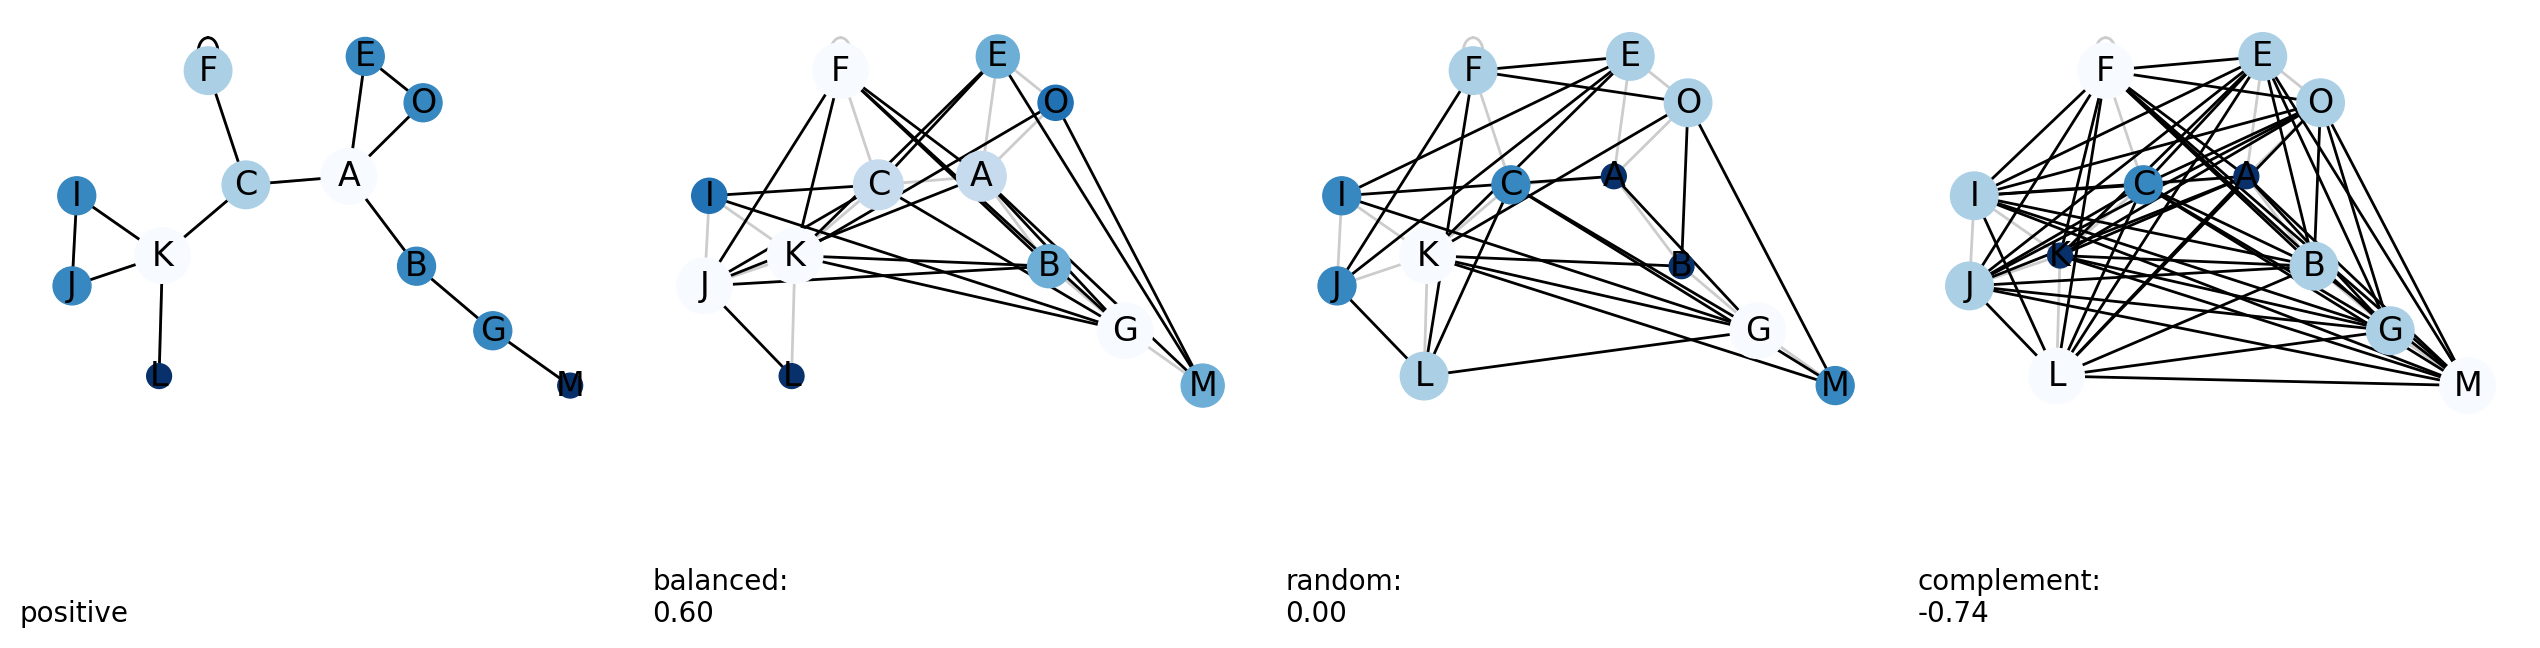

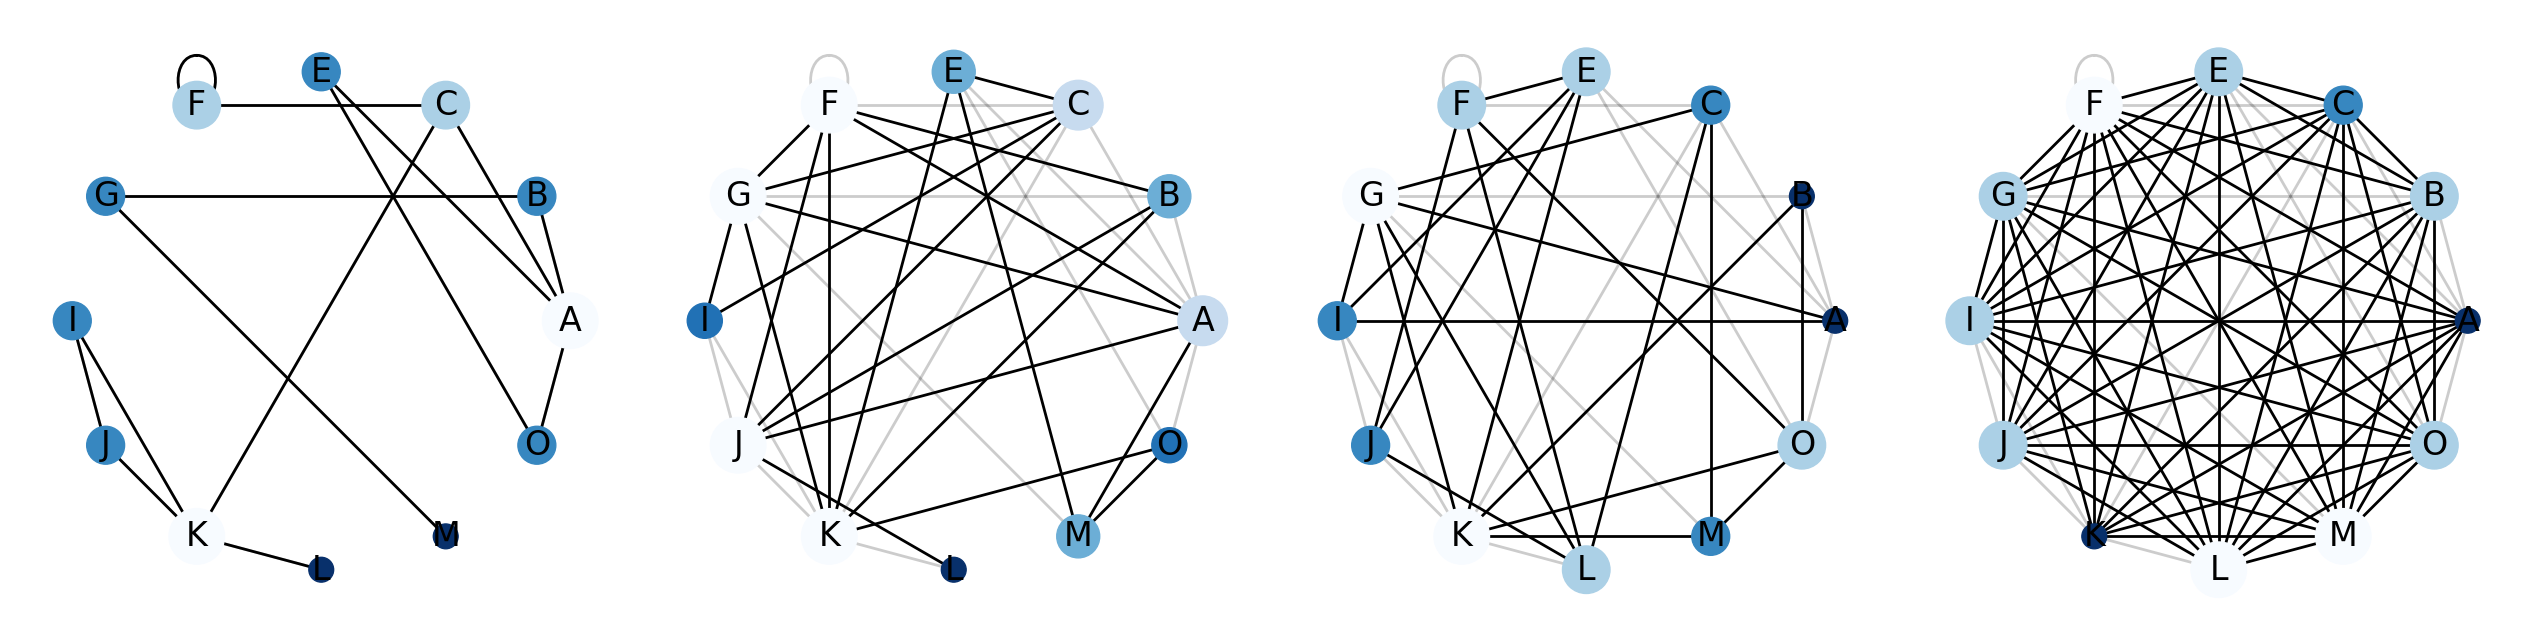

In [21]:
ppi_dict = dict()
ppi_dict['balanced'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                              strategy=SamplingStrategy.BALANCED,
                                              homodimers=False)
ppi_dict['random'], _ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                            strategy=SamplingStrategy.RANDOM,
                                            homodimers=False)
ppi_dict['complement'], _ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                strategy=SamplingStrategy.BALANCED,
                                                homodimers=False)
_ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [5]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [6]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [7]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [8]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,Q9UW12,Q9UW14,237561
1,Q8X1E6,Q9Y7W4,237561
2,A0A1D8PN90,Q8X1E6,237561
3,A0A1D8PN90,Q9Y7W4,237561
4,Q5AHJ5,Q5AHJ5,237561


#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [9]:
find_multi_species_ppis = lambda ppi_df: pd.concat(
    [df for i, df in ppi_df.groupby(
        ['UniprotID_A', 'UniprotID_B']) if len(df) > 1]
    + [ppi_df.loc[ppi_df.species == 'is there a marsupilami?']])

find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [10]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
    s.species = 'marsupilami'
    ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,Q8X1E6,Q9Y7W4,237561
1,Q8X1E6,Q9Y7W4,marsupilami
0,Q9UW12,Q9UW14,237561
0,Q9UW12,Q9UW14,marsupilami


or more generally protein IDs that occur in several species:

In [11]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### species lookup

In [12]:
# pick a charismatic animal for validation!
taxonomy = fetch_taxonomic_info(ppis.species)
taxonomy

100%|██████████| 31/31 [00:14<00:00,  2.21it/s]


,species,name,speciesn_ppis
0,632,Yersinia pestis,6
1,1392,Bacillus anthracis,4
2,3702,Arabidopsis thaliana,44723
3,6239,Caenorhabditis elegans,15257
4,7227,Drosophila melanogaster,35493
5,7955,Danio rerio,124
6,8355,Xenopus laevis,49
7,9031,Gallus gallus,40
8,9913,Bos taurus,117
9,9986,Oryctolagus cuniculus,10


#### download sequences

In [20]:
# if you are re-running this without changes above or deleting files, skip!
_ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

apid:

hash FASTA: 44854it [00:16, 2757.17it/s]
fetch isoforms/archive: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s]


#### map IDs to seq hashes

In [21]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
0,CRC-6D66674C8EFFCFAC,CRC-8131F25CFCDB91E4,243276
1,CRC-43A3E753FD4DD9C6,CRC-7E6369124A3CEC85,243276
2,CRC-43A3E753FD4DD9C6,CRC-D20D337F7D942EAE,243276
3,CRC-14F1D14AA29ACFFA,CRC-D20D337F7D942EAE,243276
4,CRC-14F1D14AA29ACFFA,CRC-F703AF702ABC919A,243276


In [22]:
len(ppis) - len(hash_ppis)

1030

In [23]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [24]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

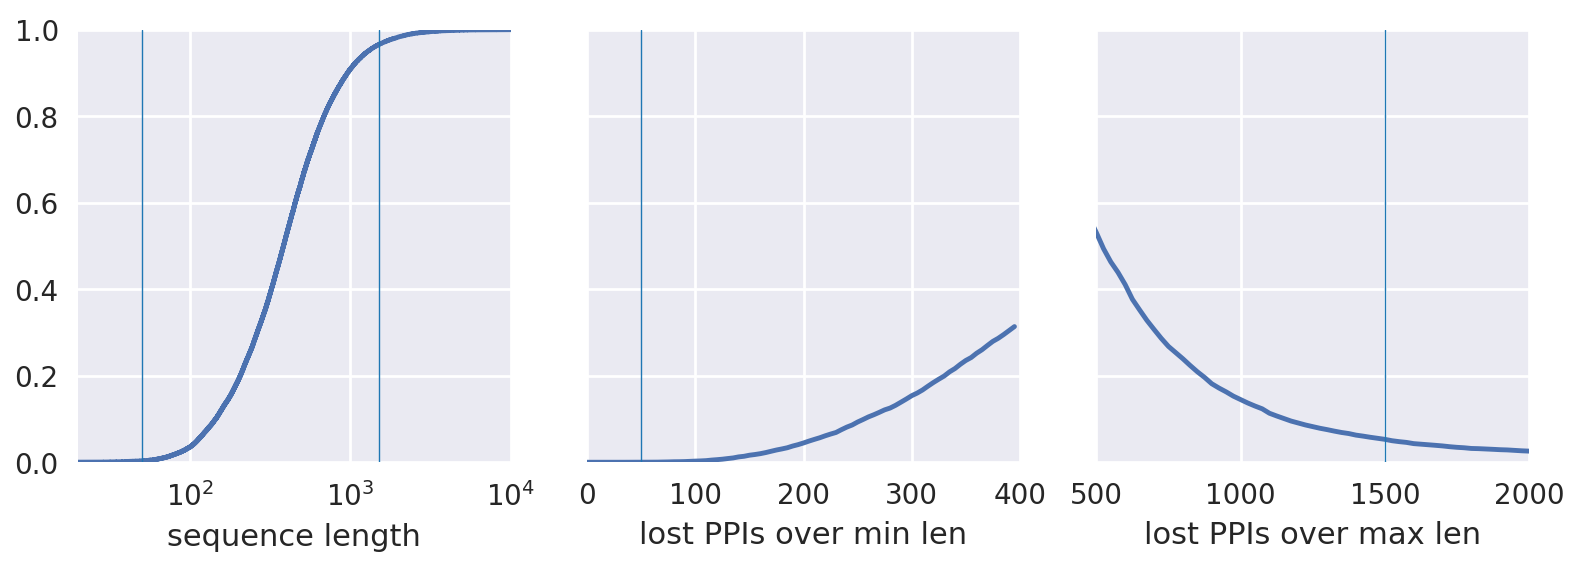

In [25]:
_hash_ppis, _fasta, fig = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [26]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

(True, 4249, 0.0281, 151143)

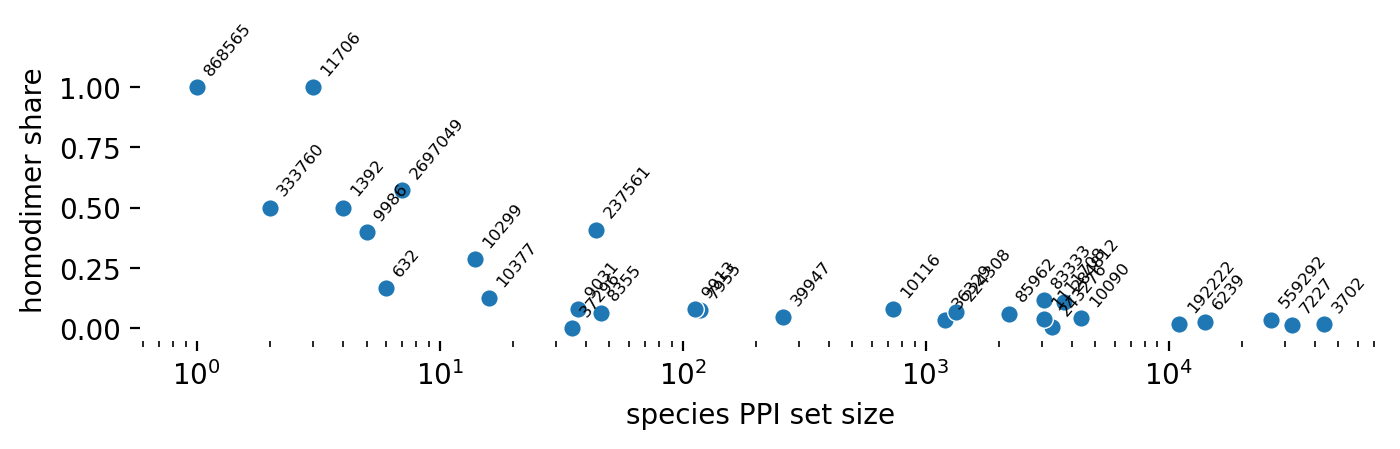

In [27]:
_ = plot_homodimer_share(hash_ppis)
c.keep_homodimers, *count_homodimers(hash_ppis),

In [28]:
if not c.keep_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
    shrink_both_ways(hash_ppis, fasta)
    len(hash_ppis), len(fasta)

## Train set: negatives

In [30]:
c.ratio, c.seed, c.strategy

(10.0, 42, <SamplingStrategy.BALANCED: 1>)

In [31]:
train_ppis, train_negs, train_bias = make_train_negatives(
    hash_ppis, ratio=c.ratio, seed=c.seed, strategy=c.strategy, homodimers=c.keep_homodimers)

sampling negatives per species! aim for 1511430


/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4490: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4490: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1510957 negatives with overall 0.967 and average per-species bias of 0.667±0.467 (std)


In [32]:
train_bias

,species,bias
0,632,-0.245495
1,1392,<NA>
2,3702,0.980112
3,6239,0.952474
4,7227,0.979164
5,7955,0.644759
6,8355,0.681739
7,9031,0.749846
8,9913,0.842287
9,9986,0.389742


#### species without negatives or a constant Spearman

In [33]:
train_bias.loc[train_bias.bias.isna()]

,species,bias
1,1392,<NA>
14,11706,<NA>
25,333760,<NA>
27,868565,<NA>


In [34]:
weird_species = set(train_bias.loc[train_bias.bias.isna(), 'species'])
train_ppis.loc[train_ppis['species'].isin(weird_species)]

,hash_A,hash_B,species,label
0,CRC-27581F82B246E112,CRC-EA8B182711929AB5,333760,1
1,CRC-EA8B182711929AB5,CRC-EA8B182711929AB5,333760,1
0,CRC-B74C3858C20EF82C,CRC-B74C3858C20EF82C,11706,1
1,CRC-8487B36BDEAC5FE4,CRC-8487B36BDEAC5FE4,11706,1
2,CRC-4BCF5059C9A7F3B2,CRC-4BCF5059C9A7F3B2,11706,1
0,CRC-69FE9D78A4BB4FEC,CRC-69FE9D78A4BB4FEC,868565,1
0,CRC-2076B4D7277317EE,CRC-3AE1EFBF48FAA03F,1392,1
1,CRC-3AE1EFBF48FAA03F,CRC-3AE1EFBF48FAA03F,1392,1
2,CRC-513D35B27B5E33B0,CRC-513D35B27B5E33B0,1392,1
3,CRC-40FB7A3A22230A1E,CRC-513D35B27B5E33B0,1392,1


In [35]:
train_negs.loc[train_negs['species'].isin(weird_species)]

,hash_A,hash_B,species,label
0,CRC-2076B4D7277317EE,CRC-513D35B27B5E33B0,1392,0
1,CRC-3AE1EFBF48FAA03F,CRC-513D35B27B5E33B0,1392,0
2,CRC-2076B4D7277317EE,CRC-40FB7A3A22230A1E,1392,0
3,CRC-3AE1EFBF48FAA03F,CRC-40FB7A3A22230A1E,1392,0
0,CRC-4BCF5059C9A7F3B2,CRC-B74C3858C20EF82C,11706,0
1,CRC-8487B36BDEAC5FE4,CRC-B74C3858C20EF82C,11706,0
2,CRC-4BCF5059C9A7F3B2,CRC-8487B36BDEAC5FE4,11706,0


This is very little data that we can safely drop. For curiosity's sake:

In [36]:
taxonomy.loc[taxonomy.species.isin(weird_species)]

,species,name,speciesn_ppis
1,1392,Bacillus anthracis,4
14,11706,HIV-1 M:B_HXB2R,3
26,333760,Human papillomavirus type 16,2
28,868565,Human herpesvirus 8 strain GK18,1


It's actually ok to just drop these organisms at this point - no need to backpropagate this farther up.

In [37]:
# actually drop the data here
train_ppis, train_negs, train_bias = [df.loc[~df.species.isin(weird_species)]
                                      for df in (train_ppis, train_negs, train_bias)]
len(train_ppis)

151133

#### set size and bias

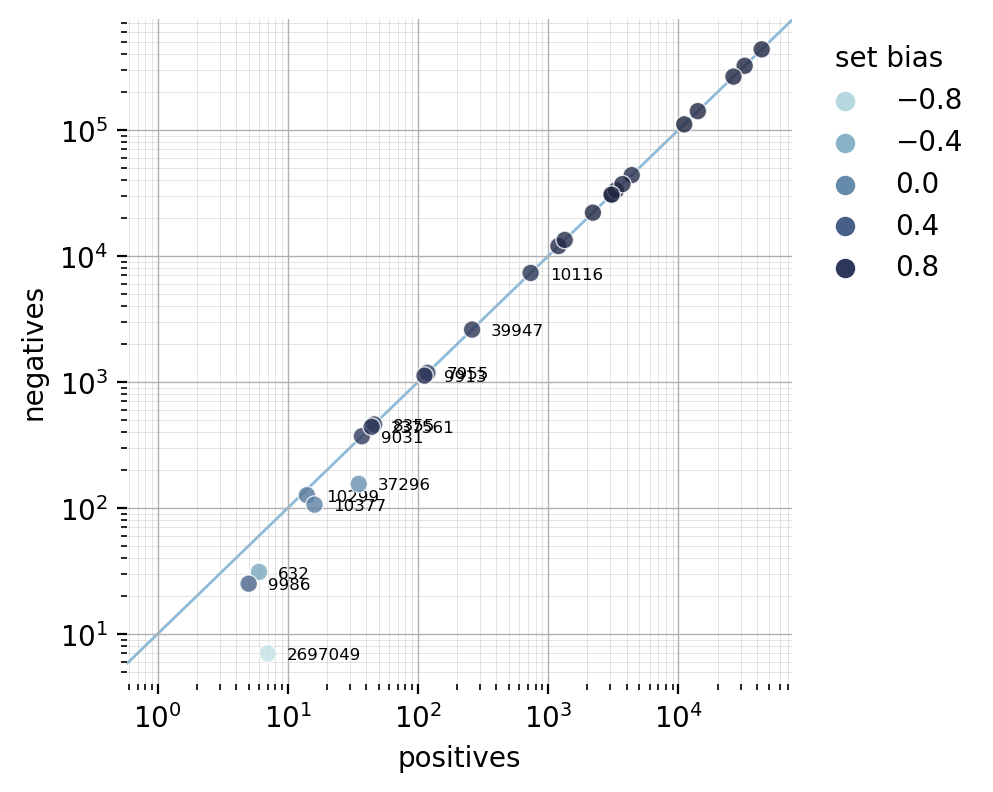

In [38]:
_ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)

## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [40]:
c.val_set_size, c.val_species

(0.1, None)

In [41]:
# # just a suggestion
# val_species = {7955, 9031, 9913, 10377, 37296, 39947}

In [42]:
train_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(train_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed! With this approach, PPIs *will* be lost
    train, val = make_validation_split(train_ppis, c.val_set_size, c.seed)
len(train), len(train) / len(train_ppis), len(val), len(val) / len(train_ppis)

14 loops


(110057, 0.7282128985727803, 19134, 0.12660371990233768)

In [43]:
val.head()

,hash_A,hash_B,species,label
0,CRC-6D66674C8EFFCFAC,CRC-8131F25CFCDB91E4,243276,1
3,CRC-14F1D14AA29ACFFA,CRC-D20D337F7D942EAE,243276,1
4,CRC-14F1D14AA29ACFFA,CRC-F703AF702ABC919A,243276,1
5,CRC-14F1D14AA29ACFFA,CRC-6E15DC2D9EDE5ED3,243276,1
8,CRC-B0209A1C981BCD92,CRC-F69F7AEC06560718,243276,1


In [44]:
val.species.unique()

array([243276,  10377,   9913,  36329, 224308,  37296,   7955,   8355,
        85962,   6239, 284812,  10116,    632, 559292])

#### train: select / re-sample negatives
We have already generated negatives above. If we want to use them, we have to drop the negatives with a protein not in the `train` PPIs, then take the rest as training set negatives. But let's also look at the bias of this cropped set! (Resample negatives for `val` later, after redundancy reduction.)

In [45]:
train_proteins = set(np.unique(train.iloc[:, [0, 1]]))
_train_negs = train_negs.loc[(train_negs.hash_A.isin(train_proteins))
                             & (train_negs.hash_B.isin(train_proteins))]
len(_train_negs), len(train_negs), len(_train_negs) / len(train_negs)

(1218421, 1510950, 0.8063939905357557)

In [46]:
estimate_bias(train, _train_negs)

SpearmanrResult(correlation=0.9182871671527069, pvalue=0.0)

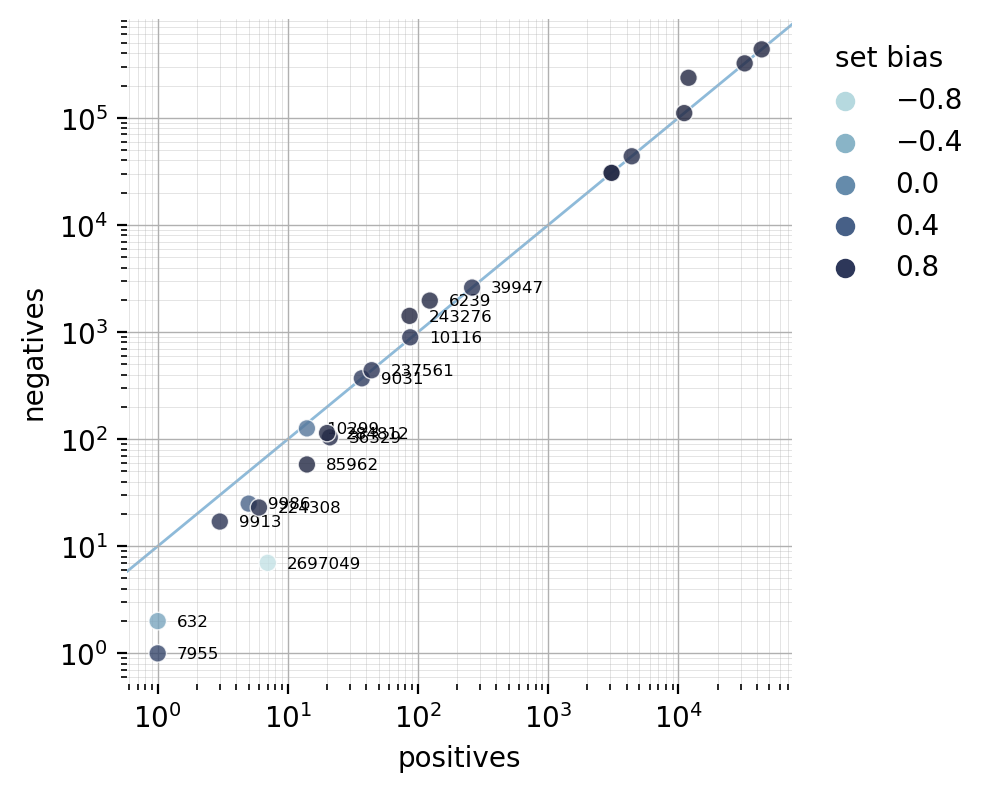

In [47]:
_ = plot_bias(train, _train_negs, train_bias, c.ratio)

Redraw a set of negative anyway to see if it would fit significantly better:

In [48]:
t_ppis, t_negs, t_bias = make_train_negatives(train, c.strategy, c.ratio, c.seed, c.keep_homodimers)

sampling negatives per species! aim for 1100570


/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4490: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4490: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4490: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1100426 negatives with overall 0.969 and average per-species bias of 0.614±0.462 (std)


In [49]:
# drop na data
t_ppis = t_ppis.loc[~t_ppis.species.isin(t_bias.loc[t_bias.bias.isna()].species)]

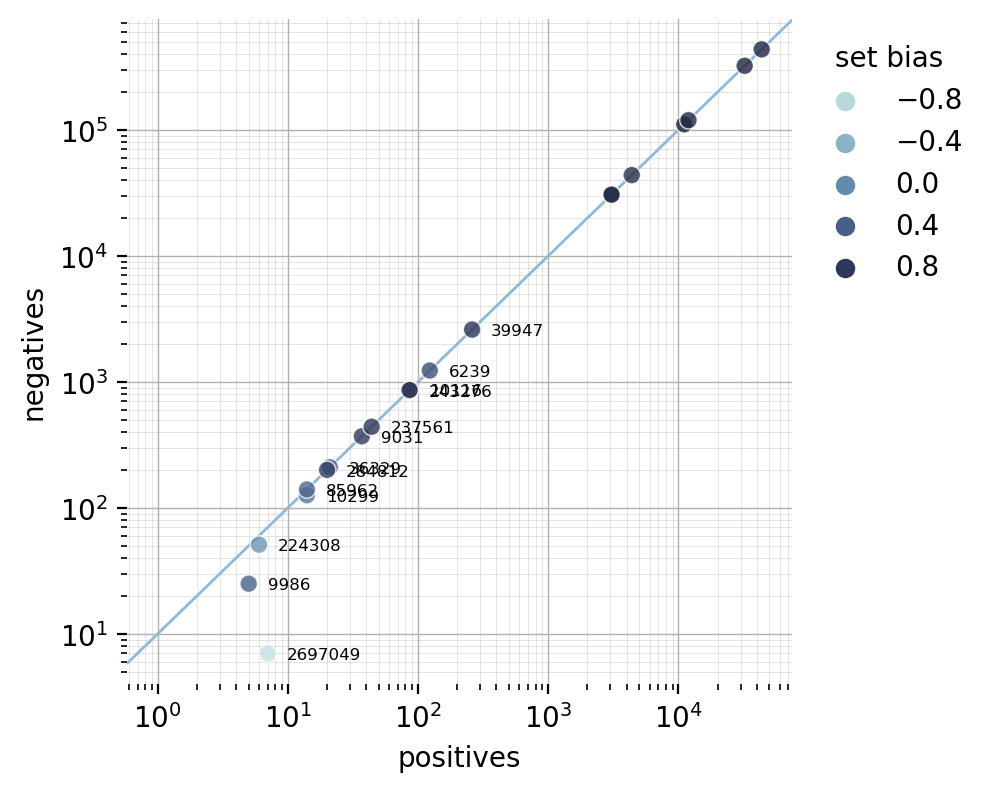

In [50]:
_ = plot_bias(t_ppis, t_negs, t_bias, c.ratio)

In [51]:
# pick one!
picked_idx = 1
train_all = [pd.concat((train, _train_negs)), pd.concat((t_ppis, t_negs))][picked_idx]
len(train_all)

1210478

Separate the validation set sequences from the ones remaining as train set

In [52]:
_, train_seqs = shrink_both_ways(train_all.copy(), fasta.copy())
len(train_seqs), len(fasta)

dropped 0/30866 table IDs and 0/1210478 rows, and 11639/42505 sequence IDs


(30866, 42505)

#### train: save


In [53]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_fasta, c.train_tsv

(PosixPath('apid_train.fasta'), PosixPath('apid_train.tsv'))

#### val: save

In [54]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/9916 table IDs and 0/19134 rows, and 32589/42505 sequence IDs


(9916, 42505)

Mind that the TSV will contain only positives! Sample negatives only after the whole `uniqueprot`-shebang.

In [55]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid_sequences/apid_validation_raw.fasta'),
 PosixPath('apid_sequences/apid_validation_raw.tsv'))

## Test set: HuRI
#### download and extract PPIs

In [57]:
c.psi_path

PosixPath('hi_union.psi')

In [58]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [59]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

In [60]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

archive batch: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


uniprot:

hash FASTA: 9040it [00:02, 3850.83it/s]
fetch isoforms/archive: 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]


9119

#### map + filter PPIs

In [61]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [62]:
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis) - len(huri_hash_ppis)

35329

In [63]:
huri_hash_ppis = remove_ids_from(huri_hash_ppis, black_list_fasta=c.train_fasta)
len(huri_hash_ppis)

61146

In [64]:
*count_homodimers(huri_hash_ppis), c.keep_homodimers

(751, 0.0123, 61146, True)

In [65]:
if not c.keep_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
    shrink_both_ways(hash_ppis, huri_seqs)
    len(huri_hash_ppis), len(huri_seqs)

dropped 1208/61146 PPIs from length filtering
dropped 0/8802 table IDs and 0/59938 rows, and 317/9119 sequence IDs


(9119, 8802)

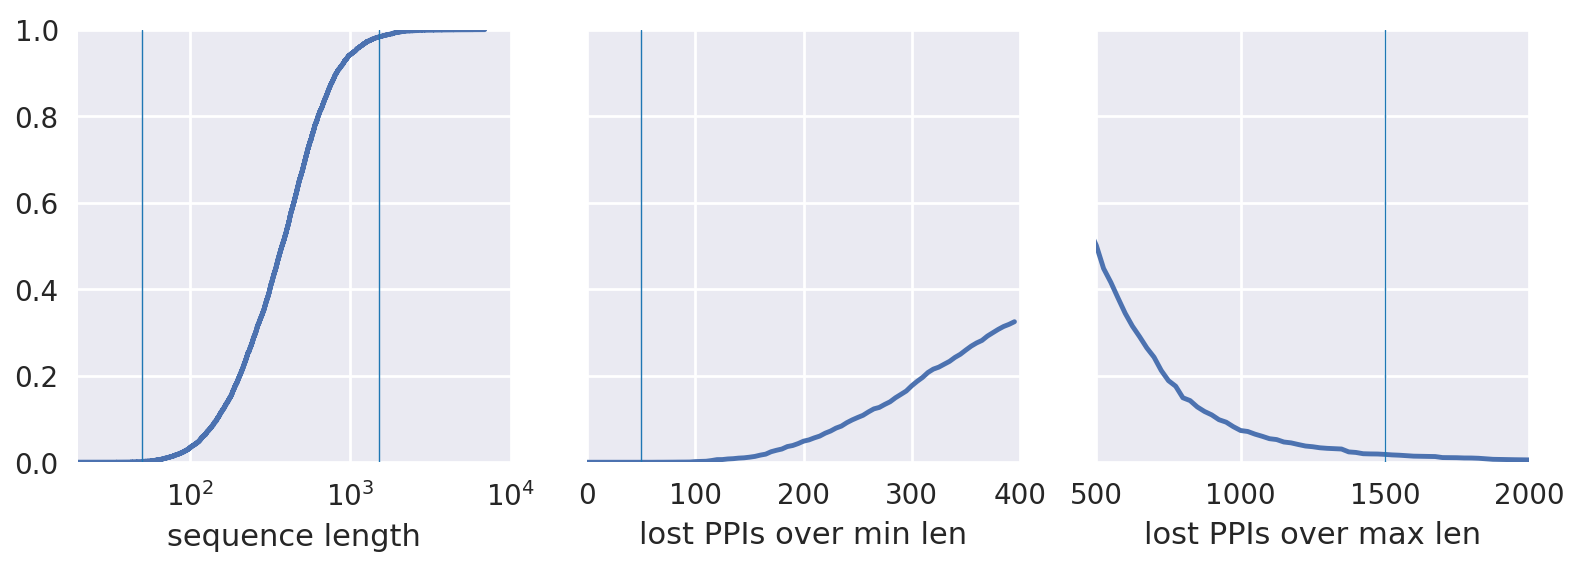

In [66]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### save to files

In [67]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri_sequences/huri_test_raw.fasta'),
 PosixPath('huri_sequences/huri_test_raw.tsv'))

## Redundancy Reduction with [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app)

**Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`. Was that name not clear?**

In [68]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

#### redundancy-reduce test and validation
The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust_pretend` at `True` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` now and here.

In [69]:
c.rostclust_pretend

True

In [70]:
!rsync -zar -e ssh "." "kaindll@lapislazuli:/home/k/kaindll/ppi/data_prep"

In [71]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta, c.hval_config, pretend=c.rostclust_pretend)

rostclust uniqueprot --work-dir ppi_rostclust --hval-config-path hval_config.json huri_sequences/huri_test_raw.fasta huri_sequences/huri_test_rr.fasta


In [72]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta, c.hval_config, pretend=c.rostclust_pretend)

rostclust uniqueprot --work-dir ppi_rostclust --hval-config-path hval_config.json apid_sequences/apid_validation_raw.fasta apid_sequences/apid_validation_rr.fasta


In [78]:
!rsync -zar -e ssh "kaindll@lapislazuli:/home/k/kaindll/ppi/data_prep/" "."

In [285]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv,
                       new_fasta_name=c.test_fasta)  # finished!
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv,
                       new_fasta_name=c.val_fasta)  # finished!

dropped 2873/8802 table IDs and 36374/59938 rows, and 749/5929 sequence IDs
dropped 2262/9916 table IDs and 8088/19134 rows, and 906/7654 sequence IDs


In [286]:
!rsync -zar -e ssh "." "kaindll@lapislazuli:/home/k/kaindll/ppi/data_prep"

#### cluster `test` and `val` against `train`

First, cluster the `HuRI` test set against the `APID` train set to get **C1-3** labels for the final test PPIs. Then, cluster the `APID` validation set against the `APID` train set, which gives us **C1-3** labels for the validation set.

In [287]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 hval_config=c.hval_config, pretend=c.rostclust_pretend)

rostclust uniqueprot2d --work-dir ppi_rostclust --hval-config-path hval_config.json huri_test.fasta apid_train.fasta huri_sequences/huri_test_c3.fasta


In [288]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 hval_config=c.hval_config, pretend=c.rostclust_pretend)

rostclust uniqueprot2d --work-dir ppi_rostclust --hval-config-path hval_config.json apid_validation.fasta apid_train.fasta apid_sequences/apid_validation_c3.fasta


In [84]:
!rsync -zar -e ssh "kaindll@lapislazuli:/home/k/kaindll/ppi/data_prep/" "."

In [85]:
assert c.test_c3_fasta.is_file()
assert c.val_c3_fasta.is_file()

## Generate negatives

Negatives are sampled *per species*. Mind that the test set is human-only!
Also, identify and assign **C1/C2/C3** class labels at this point.

In [87]:
c.ratio, c.seed, c.strategy

(10.0, 42, <SamplingStrategy.BALANCED: 1>)

#### APID val: generate & classify

In [88]:
# sanity check if there are any proteins in test that were already in train. re: "do not add back in"
assert not ({r.id for r in SeqIO.parse(c.train_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_fasta, 'fasta')})

In [89]:
for p in [c.val_rr_tsv, c.val_c3_fasta, c.val_fasta]:
    assert p.is_file(), f'missing {p}'

In [90]:
val_ppis, val_negatives, val_bias = make_test_negatives(
    c.val_rr_tsv, c.val_c3_fasta, c.val_fasta, c.strategy,
    c.ratio, c.seed, c.keep_homodimers)
val_negatives.head()

11046
apid_sequences/apid_validation_rr.fasta
sampling negatives per species! aim for 110460
110214 negatives with overall 0.912 and average per-species bias of 0.658±0.405 (std)
11046


,hash_A,hash_B,species,cclass,label
0,CRC-48F409F4E28F37BE,CRC-D4C3706260D2937A,632,2,0
1,CRC-9AC87796A0BA67D9,CRC-BED64D5961AA5E38,632,2,0
2,CRC-BED64D5961AA5E38,CRC-BED64D5961AA5E38,632,1,0
3,CRC-9AC87796A0BA67D9,CRC-D4C3706260D2937A,632,2,0
4,CRC-D4C3706260D2937A,CRC-D4C3706260D2937A,632,1,0


In [290]:
val_ppis.head()

,hash_A,hash_B,species,label,cclass
0,CRC-B0209A1C981BCD92,CRC-F69F7AEC06560718,243276,1,2
1,CRC-142F5BCB0423CAB1,CRC-3AF0BCBE16EB5D4F,243276,1,3
2,CRC-16344A3FB94281EE,CRC-B8D92ECCF94BE2A5,243276,1,3
3,CRC-1DA9CC7E4FBE2794,CRC-31634655A577A5FF,243276,1,3
4,CRC-1DA9CC7E4FBE2794,CRC-37422ECBF0D8D894,243276,1,3


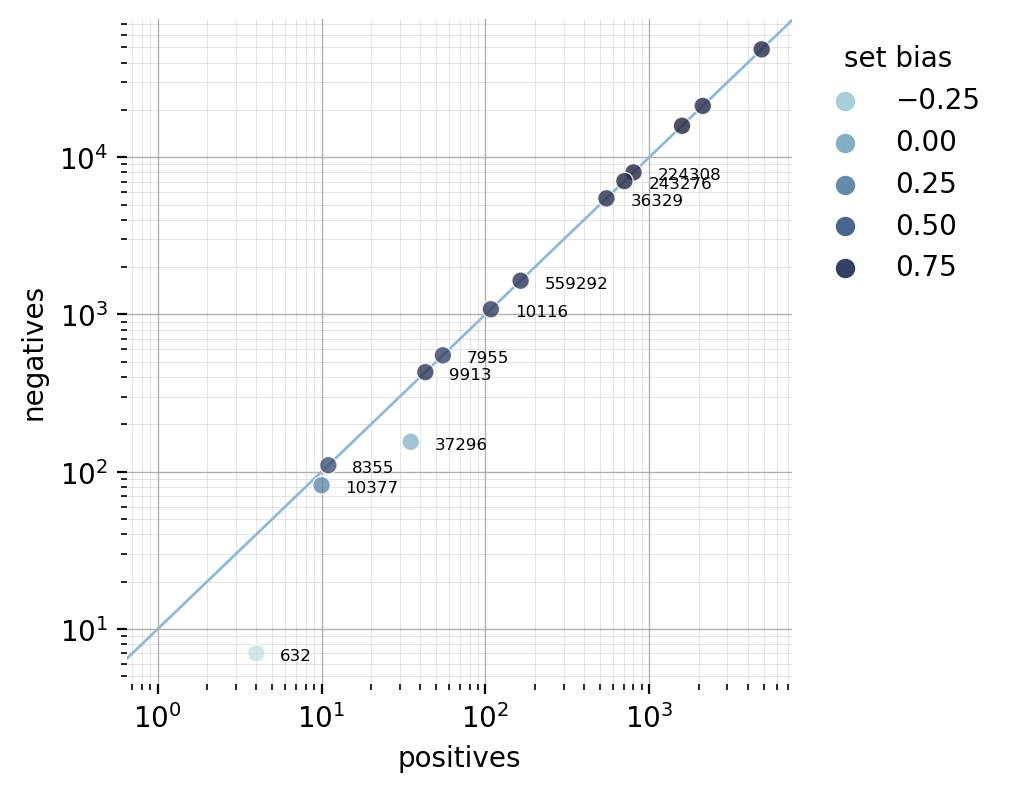

In [92]:
_ = plot_bias(val_ppis, val_negatives, val_bias, c.ratio)

In [93]:
val_all = pd.concat([val_ppis, val_negatives])
len(val_all)

121260

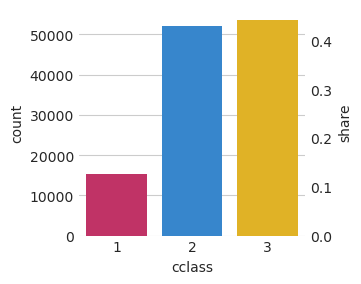

In [191]:
with mpl.rc_context({'figure.dpi': 100}):
    _ = plot_c_classes(val_all.cclass)

In [279]:
# have a direct look at the (ranked) degrees, but only for some species
n_degrees_per_sp = fetch_degrees(val_all).groupby('species')[
    'x'].size().sort_values(ascending=False)
# pick two larger and two smaller species sets
sps = list(n_degrees_per_sp.index)[:2] + list(n_degrees_per_sp.index)[-5:-3]
print(sps)
n_degrees_per_sp

[6239, 284812, 9913, 8355]


species
6239      9135
284812    4686
85962     2786
36329     1561
243276    1221
224308    1170
559292     609
10116      458
7955       198
9913       134
8355        52
37296       40
10377       28
632         14
Name: x, dtype: int64

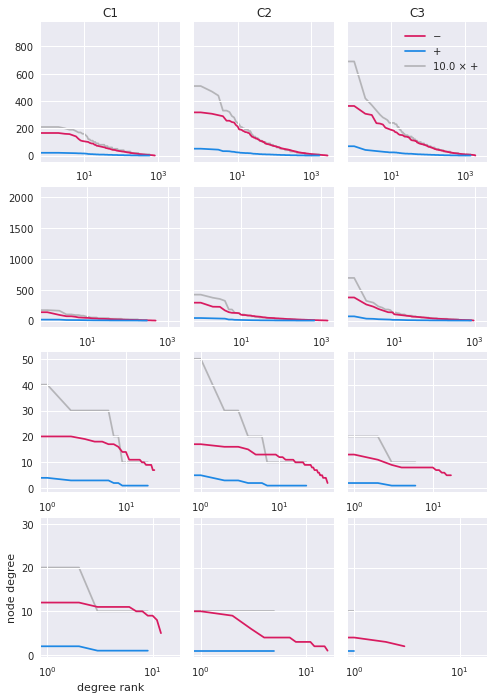

In [280]:
with mpl.rc_context({'figure.dpi': 72}):
    # can't unFUBAR the axis limits ...
    _ = plot_test_degrees(val_all.loc[val_all.species.isin(sps)], c.ratio, flip=False)

#### APID val: save TSV
The `FASTA` was finalized already, right after the redundancy reduction and before clustering against `train`.

In [284]:
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

#### HuRI test: generate & classify

In [289]:
for p in [c.test_rr_tsv, c.test_c3_fasta, c.test_fasta]:
    assert p.is_file(), f'missing {p}'

In [ ]:
c.huri_rr_fasta.with_suffix('.tsv')

In [291]:
test_ppis, test_negatives, test_bias = make_test_negatives(
    c.test_rr_tsv, c.test_c3_fasta, c.test_fasta, c.strategy,
    c.ratio, c.seed, c.keep_homodimers)
test_negatives.head()

23564
huri_test.fasta
aim for 235640 negatives; upper limit is 13390512
got 235640 negatives with bias 0.978
23564


,hash_A,hash_B,species,cclass,label
0,CRC-000037AE195F7A9D,CRC-0518B04A0E991529,9606,2,0
1,CRC-000037AE195F7A9D,CRC-B470B4ADC5C16821,9606,2,0
2,CRC-000624825E507385,CRC-65B3683767990740,9606,3,0
3,CRC-000624825E507385,CRC-8C139BEBE5687861,9606,3,0
4,CRC-000624825E507385,CRC-A68B0F034B5BE83F,9606,3,0


In [292]:
test_ppis.head()

,hash_A,hash_B,species,cclass,label
0,CRC-450D36A80D6D88C8,CRC-8A19DDC376DCD0F4,9606,1,1
1,CRC-4CB899386D443FEA,CRC-9C54AFA126F17AF1,9606,2,1
2,CRC-1211E96DDC0A3182,CRC-B7F0D1D01ADFDFE7,9606,1,1
3,CRC-23F4C21E7327DE3D,CRC-8E2B9CB2B8FB72AD,9606,3,1
4,CRC-79AE0E5DF5488CA1,CRC-EA627A87958B83B6,9606,3,1


In [294]:
test_all = pd.concat([test_ppis, test_negatives])
len(test_all)

259204

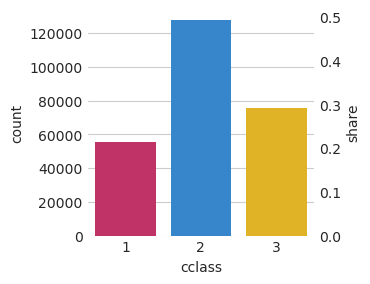

In [321]:
with mpl.rc_context({'figure.dpi': 100}):
    _ = plot_c_classes(test_all.cclass)

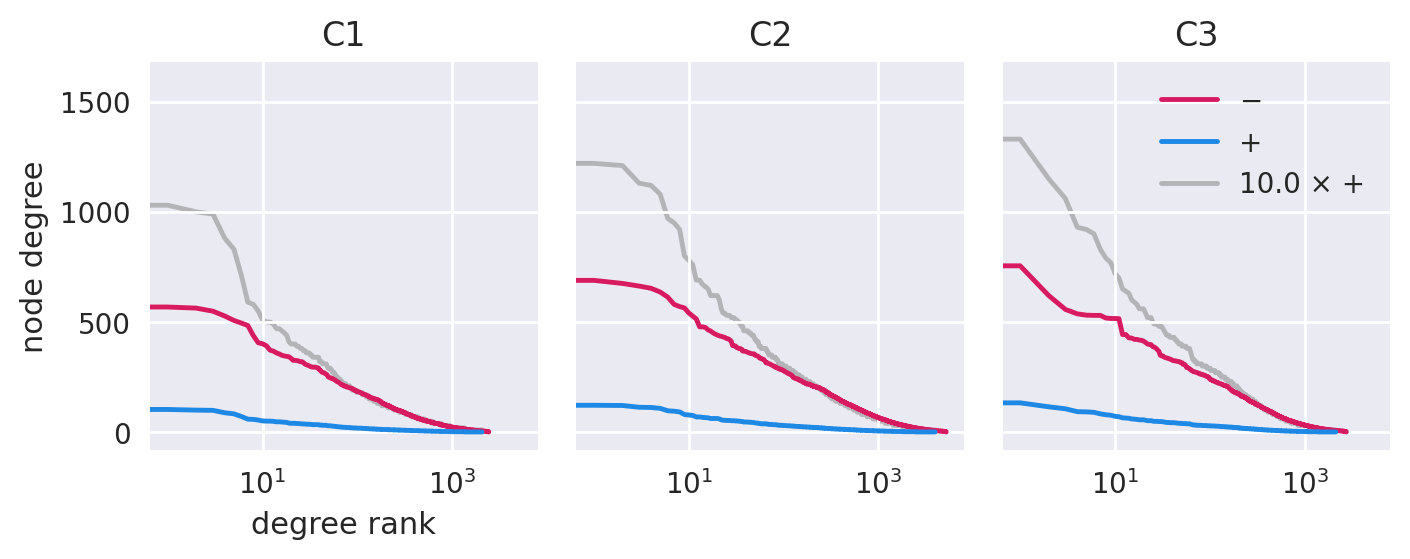

In [313]:
_ = plot_test_degrees(test_all, c.ratio)

#### HuRI test: save TSV

In [314]:
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

In [317]:
with Path('cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "keep_homodimers": true,
  "rostclust_pretend": true,
  "ap": "apid_sequences",
  "hp": "huri_sequences",
  "qp": "apid_q1",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": null,
  "val_raw_fasta": "apid_sequences/apid_validation_raw.fasta",
  "val_raw_tsv": "apid_sequences/apid_validation_raw.tsv",
  "val_rr_fasta": "apid_sequences/apid_validation_rr.fasta",
  "val_rr_tsv": "apid_sequences/apid_validation_rr.tsv",
  "val_c3_fasta": "apid_sequences/apid_validation_c3.fasta",
  "val_fasta": "apid_validation.fasta",
  "val_tsv": "apid_validation.tsv",
  "test_raw_fasta": "huri_sequences/huri_test_raw.fasta",
  "test_raw_tsv": "huri_sequences/huri_test_raw.tsv",
  "test_rr_fasta": "huri_sequences/huri_test_rr.fasta",


In [322]:
!rsync -zar -e ssh "." "kaindll@lapislazuli:/home/k/kaindll/ppi/data_prep"